In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import albumentations as A


# Step 1: Preprocess and load the WSI data
train_data_directory = '/content/drive/MyDrive/Train_Set_2'
test_data_directory = '/content/drive/MyDrive/Test'
img_height, img_width = 299, 299
batch_size = 32
num_classes = 3

# Data augmentation using Albumentations
def apply_augmentation(image):
    augment = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=45),
        A.RandomZoom(p=0.2),
    ])
    augmented = augment(image=image)
    return augmented['image']

# Custom generator with Albumentations
class AugmentedImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_data_generator, augment_fn, *args, **kwargs):
        self.image_data_generator = image_data_generator
        self.augment_fn = augment_fn
        self.batch_transform_args = args
        self.batch_transform_kwargs = kwargs

    def __len__(self):
        return len(self.image_data_generator)

    def __getitem__(self, idx):
        x, y = self.image_data_generator[idx]
        x = self.augment_fn(x, *self.batch_transform_args, **self.batch_transform_kwargs)
        return x, y

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
train_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create augmented training generator
train_augmented_generator = AugmentedImageDataGenerator(train_generator, apply_augmentation)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
validation_generator = validation_datagen.flow_from_directory(
    train_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Step 2: Load the InceptionV3 model and modify it for transfer learning
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Step 3: Freeze some layers in the base model for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

# Step 5: Evaluate the model on the test set
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Step 6: Compute category-wise accuracy and F1 score

accuracy_per_class = {}
f1_per_class = {}

class_names = list(test_generator.class_indices.keys())

for class_name in class_names:
    indices = np.where(y_true == test_generator.class_indices[class_name])[0]
    accuracy_per_class[class_name] = np.mean(y_true[indices] == y_pred[indices])
    f1_per_class[class_name] = f1_score(y_true[indices], y_pred[indices], average='weighted')

print("Category-wise Accuracy:")
for class_name, acc in accuracy_per_class.items():
    print(f"{class_name}: {acc:.2f}")

print("\nCategory-wise F1 Score:")
for class_name, f1 in f1_per_class.items():
    print(f"{class_name}: {f1:.2f}")

# Compute overall accuracy and F1 score
overall_accuracy = np.mean(y_true == y_pred)
overall_f1 = f1_score(y_true, y_pred, average='weighted')
print("\nOverall Accuracy:", overall_accuracy)
print("Overall F1 Score:", overall_f1)

Found 186 images belonging to 3 classes.
Found 0 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/10
5/5 [==============================] - 83s 13s/step - loss: 1.2415 - accuracy: 0.2857
Epoch 2/10
5/5 [==============================] - 52s 9s/step - loss: 0.9935 - accuracy: 0.5130
Epoch 3/10
5/5 [==============================] - 54s 10s/step - loss: 0.8796 - accuracy: 0.6187
Epoch 4/10
5/5 [==============================] - 54s 10s/step - loss: 0.7592 - accuracy: 0.7273
Epoch 5/10
5/5 [==============================] - 57s 10s/step - loss: 0.7198 - accuracy: 0.7338
Epoch 6/10
5/5 [==============================] - 52s 10s/step - loss: 0.6438 - accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 53s 10s/step - loss: 0.6036 - accuracy: 0.8571
Epoch 8/10
5/5 [==============================] - 53s 10s/step - loss: 0.5473 - accuracy: 0.8636
Epoch 9/10
5/5 [========================

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Preprocess and load the WSI data
train_data_directory = '/content/drive/MyDrive/Train_Set_2'
test_data_directory = '/content/drive/MyDrive/Test'
img_height, img_width = 299, 299
batch_size = 32
num_classes = 3

# Albumentations augmentation
def albumentations_augmentation(image):
    transform = A.Compose([
        A.Rotate(limit=45),
        A.RandomResizedCrop(height=img_height, width=img_width, scale=(0.8, 1.2)),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=45),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20),
        A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.5),
    ])
    augmented = transform(image=image)
    return augmented['image']

# Data augmentation using Albumentations and TensorFlow's ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    preprocessing_function=albumentations_augmentation,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

class_names = list(test_generator.class_indices.keys())

# Step 2: Load the InceptionV3 model and modify it for transfer learning
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Step 3: Freeze some layers in the base model for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

# Step 5: Evaluate the model on the test set
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Step 6: Compute category-wise accuracy and F1 score

accuracy_per_class = {}
f1_per_class = {}

for class_name in class_names:
    indices = np.where(y_true == test_generator.class_indices[class_name])[0]
    accuracy_per_class[class_name] = np.mean(y_true[indices] == y_pred[indices])
    f1_per_class[class_name] = f1_score(y_true[indices], y_pred[indices], average='weighted')

print("Category-wise Accuracy:")
for class_name, acc in accuracy_per_class.items():
    print(f"{class_name}: {acc:.2f}")

print("\nCategory-wise F1 Score:")
for class_name, f1 in f1_per_class.items():
    print(f"{class_name}: {f1:.2f}")

# Compute overall accuracy and F1 score
overall_accuracy = np.mean(y_true == y_pred)
overall_f1 = f1_score(y_true, y_pred, average='weighted')
print("\nOverall Accuracy:", overall_accuracy)
print("Overall F1 Score:", overall_f1)

Found 149 images belonging to 3 classes.
Found 37 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Epoch 1/10
4/4 [==============================] - 75s 18s/step - loss: 1.1124 - accuracy: 0.4188 - val_loss: 1.1423 - val_accuracy: 0.3438
Epoch 2/10
4/4 [==============================] - 64s 16s/step - loss: 1.0964 - accuracy: 0.3761 - val_loss: 1.1084 - val_accuracy: 0.3125
Epoch 3/10
4/4 [==============================] - 62s 16s/step - loss: 1.1329 - accuracy: 0.3504 - val_loss: 1.1876 - val_accuracy: 0.3438
Epoch 4/10
4/4 [==============================] - 54s 15s/step - loss: 1.1278 - accuracy: 0.3162 - val_loss: 1.1604 - val_accuracy: 0.3438
Epoch 5/10
4/4 [==============================] - 53s 15s/step - loss: 1.0676 - accuracy: 0.3761 - val_loss: 1.1978 - val_accuracy: 0.3438
Epoch 6/10
4/4 [==============================] - 52s 15s/step - loss: 1.0963 - accuracy: 0.3504 - val_loss: 1.1876 - val_accuracy: 0.3125
Epoch 7/10
4/4 [=============================

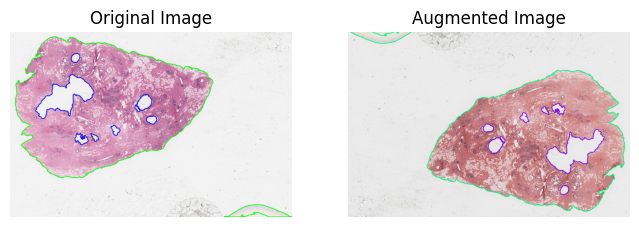

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# Example usage to visualize augmentation for a single image
image_path = '/content/drive/MyDrive/Train_Set_2/Pre-Cancerous/BRACS_1971.jpg'  # Replace with the path to the image you want to visualize

# Function to apply Albumentations augmentation to a single image
def apply_augmentation_to_single_image(image_path):
    image = Image.open(image_path)
    image_np = np.array(image)
    augment = A.Compose([
        A.Rotate(limit=45),
        #A.RandomResizedCrop(height=img_height, width=img_width, scale=(0.8, 1.2)),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=45),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20),
        A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.5),
    ])
    augmented = augment(image=image_np)
    augmented_image = augmented['image']
    return augmented_image

augmented_image = apply_augmentation_to_single_image(image_path)

# Plot the original and augmented images side by side
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title('Augmented Image')
plt.axis('off')

plt.show()

In [5]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch  # Import the torch module
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

import tensorflow as tf
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,accuracy_score,f1_score,precision_score

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

import tensorflow as tf
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,accuracy_score,f1_score,precision_score
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3,MobileNet

# Step 1: Preprocess and load the WSI data
train_data_directory = '//content/drive/MyDrive/Train_Set_2'  # Directory containing training patches
test_data_directory = '//content/drive/MyDrive/Test'    # Directory containing test patches

img_height, img_width = 299, 299  # InceptionV3 input size
batch_size = 32
num_classes = 3  # Number of classes: cancerous, precancerous, and non-cancerous

# Define Albumentations transformations
train_transform = A.Compose([
    A.Resize(img_height, img_width),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.Normalize(),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(img_height, img_width),
    A.Normalize(),
    ToTensorV2()
])

# Create custom data loaders using Albumentations and PyTorch
from torchvision import datasets, transforms

class CustomDataset(datasets.ImageFolder):
    def __init__(self, data_directory, transform=None):
        super().__init__(root=data_directory, transform=transform)


# Create ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load and preprocess the training and test data
train_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False
)



# Load and preprocess the training and test data using Albumentations
train_dataset = CustomDataset(train_data_directory, transform=train_transform)
test_dataset = CustomDataset(test_data_directory, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Step 2: Load the InceptionV3 model and modify it for transfer learning
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a final softmax layer for multi-class classification
predictions = Dense(num_classes, activation='softmax')(x)

# Combine the base model and the new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Step 3: Freeze some layers in the base model for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10  # Choose the number of epochs suitable for your dataset
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs
)

# Step 5: Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {accuracy:.2f}")




# Step 5: Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, steps=None)
print(f"Test accuracy: {accuracy:.2f}")

# Step 6: Compute category-wise accuracy and F1 score
y_true = test_generator.classes
y_pred = model.predict(test_generator, steps=None).argmax(axis=1)

class_names = list(test_generator.class_indices.keys())

# Compute category-wise accuracy
accuracy_per_class = {}
for class_name in class_names:
  indices = np.where(y_true == test_generator.class_indices[class_name])[0]
  accuracy_per_class[class_name] = np.mean(y_true[indices] == y_pred[indices])

print("Category-wise Accuracy:")
for class_name, acc in accuracy_per_class.items():
  print(f"{class_name}: {acc:.2f}")

# Compute category-wise F1 score
f1_per_class = {}
for class_name in class_names:
  indices = np.where(y_true == test_generator.class_indices[class_name])[0]
  f1_per_class[class_name] = f1_score(y_true[indices], y_pred[indices], average='weighted')

print("\nCategory-wise F1 Score:")
for class_name, f1 in f1_per_class.items():
  print(f"{class_name}: {f1:.2f}")

# Compute overall accuracy and F1 score
overall_accuracy = np.mean(y_true == y_pred)
overall_f1 = f1_score(y_true, y_pred, average='weighted')
print("\nOverall Accuracy:", overall_accuracy)
print("Overall F1 Score:", overall_f1)

# Step 7: Check count of images in each category in test data
test_data_counts = {}
for class_name in class_names:
    class_directory = os.path.join(test_data_directory, class_name)
    num_images = len(os.listdir(class_directory))
    test_data_counts[class_name] = num_images

print("\nCount of Images in Each Category in Test Data:")
for class_name, count in test_data_counts.items():
    print(f"{class_name}: {count}")

Found 186 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 63s 11s/step - loss: 1.1260 - accuracy: 0.3312
Epoch 2/10
5/5 [==============================] - 57s 10s/step - loss: 1.0125 - accuracy: 0.4313
Epoch 3/10
5/5 [==============================] - 55s 11s/step - loss: 0.9039 - accuracy: 0.5909
Epoch 4/10
5/5 [==============================] - 56s 10s/step - loss: 0.8476 - accuracy: 0.6948
Epoch 5/10
5/5 [==============================] - 57s 11s/step - loss: 0.7871 - accuracy: 0.7013
Epoch 6/10
5/5 [==============================] - 57s 11s/step - loss: 0.7395 - accuracy: 0.7273
Epoch 7/10
5/5 [==============================] - 57s 10s/step - loss: 0.6610 - accuracy: 0.8117
Epoch 8/10
5/5 [==============================] - 59s 11s/step - loss: 0.6722 - accuracy: 0.7625
Epoch 9/10
5/5 [==============================] - 66s 12s/step - loss: 0.6874 - accuracy: 0.6938
Epoch 10/10
2/2 [=============================

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Step 1: Preprocess and load the WSI data
train_data_directory = '/content/drive/MyDrive/Train_Set_2'
test_data_directory = '/content/drive/MyDrive/Test'
img_height, img_width = 299, 299
batch_size = 32
num_classes = 3

# Define Albumentations transformations
train_transform = A.Compose([
    A.Resize(img_height, img_width),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.Normalize(),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(img_height, img_width),
    A.Normalize(),
    ToTensorV2()
])

# Custom generator with Albumentations
class AugmentedImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_data_generator, augment_fn, *args, **kwargs):
        self.image_data_generator = image_data_generator
        self.augment_fn = augment_fn
        self.batch_transform_args = args
        self.batch_transform_kwargs = kwargs

    def __len__(self):
        return len(self.image_data_generator)

    def __getitem__(self, idx):
        x, y = self.image_data_generator[idx]
        x = self.augment_fn(x, *self.batch_transform_args, **self.batch_transform_kwargs)
        return x, y

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
train_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create augmented training generator
train_augmented_generator = AugmentedImageDataGenerator(train_generator, train_transform)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Step 2: Load the InceptionV3 model and modify it for transfer learning
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Step 3: Freeze some layers in the base model for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs
)

# Step 5: Evaluate the model on the test set
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Step 6: Compute category-wise accuracy and F1 score

accuracy_per_class = {}
f1_per_class = {}

class_names = list(test_generator.class_indices.keys())

for class_name in class_names:
    indices = np.where(y_true == test_generator.class_indices[class_name])[0]
    accuracy_per_class[class_name] = np.mean(y_true[indices] == y_pred[indices])
    f1_per_class[class_name] = f1_score(y_true[indices], y_pred[indices], average='weighted')

print("Category-wise Accuracy:")
for class_name, acc in accuracy_per_class.items():
    print(f"{class_name}: {acc:.2f}")

print("\nCategory-wise F1 Score:")
for class_name, f1 in f1_per_class.items():
    print(f"{class_name}: {f1:.2f}")

# Compute overall accuracy and F1 score
overall_accuracy = np.mean(y_true == y_pred)
overall_f1 = f1_score(y_true, y_pred, average='weighted')
print("\nOverall Accuracy:", overall_accuracy)
print("Overall F1 Score:", overall_f1)

Found 186 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 60s 10s/step - loss: 1.1294 - accuracy: 0.3875
Epoch 2/10
5/5 [==============================] - 51s 10s/step - loss: 0.9531 - accuracy: 0.5390
Epoch 3/10
5/5 [==============================] - 52s 9s/step - loss: 0.8639 - accuracy: 0.6104
Epoch 4/10
5/5 [==============================] - 51s 9s/step - loss: 0.7527 - accuracy: 0.7597
Epoch 5/10
5/5 [==============================] - 59s 11s/step - loss: 0.6954 - accuracy: 0.7468
Epoch 6/10
5/5 [==============================] - 56s 10s/step - loss: 0.6233 - accuracy: 0.8188
Epoch 7/10
5/5 [==============================] - 56s 10s/step - loss: 0.5629 - accuracy: 0.8625
Epoch 8/10
5/5 [==============================] - 52s 9s/step - loss: 0.5527 - accuracy: 0.8506
Epoch 9/10
5/5 [==============================] - 53s 10s/step - loss: 0.5019 - accuracy: 0.9091
Epoch 10/10
3/3 [==============================] 

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Step 1: Preprocess and load the WSI data
train_data_directory = '/content/drive/MyDrive/Train_Set_2'
test_data_directory = '/content/drive/MyDrive/Test'
img_height, img_width = 224, 224  # ResNet50 input size is (224, 224, 3)
batch_size = 32
num_classes = 3

# Define Albumentations transformations
train_transform = A.Compose([
    A.Resize(img_height, img_width),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.Normalize(),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(img_height, img_width),
    A.Normalize(),
    ToTensorV2()
])

# Custom generator with Albumentations
class AugmentedImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_data_generator, augment_fn, *args, **kwargs):
        self.image_data_generator = image_data_generator
        self.augment_fn = augment_fn
        self.batch_transform_args = args
        self.batch_transform_kwargs = kwargs

    def __len__(self):
        return len(self.image_data_generator)

    def __getitem__(self, idx):
        x, y = self.image_data_generator[idx]
        x = self.augment_fn(x, *self.batch_transform_args, **self.batch_transform_kwargs)
        return x, y

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
train_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create augmented training generator
train_augmented_generator = AugmentedImageDataGenerator(train_generator, train_transform)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Step 2: Load the ResNet50 model and modify it for transfer learning
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Step 3: Freeze some layers in the base model for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs
)

# Step 5: Evaluate the model on the test set
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Step 6: Compute category-wise accuracy and F1 score

accuracy_per_class = {}
f1_per_class = {}

class_names = list(test_generator.class_indices.keys())

for class_name in class_names:
    indices = np.where(y_true == test_generator.class_indices[class_name])[0]
    accuracy_per_class[class_name] = np.mean(y_true[indices] == y_pred[indices])
    f1_per_class[class_name] = f1_score(y_true[indices], y_pred[indices], average='weighted')

print("Category-wise Accuracy:")
for class_name, acc in accuracy_per_class.items():
    print(f"{class_name}: {acc:.2f}")

print("\nCategory-wise F1 Score:")
for class_name, f1 in f1_per_class.items():
    print(f"{class_name}: {f1:.2f}")

# Compute overall accuracy and F1 score
overall_accuracy = np.mean(y_true == y_pred)
overall_f1 = f1_score(y_true, y_pred, average='weighted')
print("\nOverall Accuracy:", overall_accuracy)
print("Overall F1 Score:", overall_f1)

Found 186 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
5/5 [==============================] - 53s 9s/step - loss: 1.1300 - accuracy: 0.3506
Epoch 2/10
5/5 [==============================] - 47s 8s/step - loss: 1.1176 - accuracy: 0.3831
Epoch 3/10
5/5 [==============================] - 46s 8s/step - loss: 1.1237 - accuracy: 0.3312
Epoch 4/10
5/5 [==============================] - 47s 8s/step - loss: 1.1166 - accuracy: 0.3247
Epoch 5/10
5/5 [==============================] - 45s 9s/step - loss: 1.1317 - accuracy: 0.3506
Epoch 6/10
5/5 [==============================] - 54s 9s/step - loss: 1.0953 - accuracy: 0.3636
Epoch 7/10
5/5 [==============================] - 46s 9s/step - loss: 1.0946 - accuracy: 0.3506
Epoch 8/10
5/5 [==============================] - 47s 8s/step - loss: 1.0844 - accuracy: 0.4250
Epoch 9/10
5/5 [==============================] - 45s 9s/step - loss: 1.0879 - accurac

3/3 [==============================] - 24s 5s/step
Category-wise Accuracy:
Cancerous: 0.00
Non-Cancerous: 0.00
Pre-Cancerous: 0.96

Category-wise F1 Score:
Cancerous: 0.00
Non-Cancerous: 0.00
Pre-Cancerous: 0.98

Overall Accuracy: 0.275
Overall F1 Score: 0.12524752475247525


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Step 1: Preprocess and load the WSI data
train_data_directory = '/content/drive/MyDrive/Train_Set_2'
test_data_directory = '/content/drive/MyDrive/Test'
img_height, img_width = 224, 224  # MobileNet input size is (224, 224, 3)
batch_size = 32
num_classes = 3

# Define Albumentations transformations
train_transform = A.Compose([
    A.Resize(img_height, img_width),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.Normalize(),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(img_height, img_width),
    A.Normalize(),
    ToTensorV2()
])

# Custom generator with Albumentations
class AugmentedImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_data_generator, augment_fn, *args, **kwargs):
        self.image_data_generator = image_data_generator
        self.augment_fn = augment_fn
        self.batch_transform_args = args
        self.batch_transform_kwargs = kwargs

    def __len__(self):
        return len(self.image_data_generator)

    def __getitem__(self, idx):
        x, y = self.image_data_generator[idx]
        x = self.augment_fn(x, *self.batch_transform_args, **self.batch_transform_kwargs)
        return x, y

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
train_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create augmented training generator
train_augmented_generator = AugmentedImageDataGenerator(train_generator, train_transform)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Step 2: Load the MobileNet model and modify it for transfer learning
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Step 3: Freeze some layers in the base model for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs
)

# Step 5: Evaluate the model on the test set
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Step 6: Compute category-wise accuracy and F1 score

accuracy_per_class = {}
f1_per_class = {}

class_names = list(test_generator.class_indices.keys())

for class_name in class_names:
    indices = np.where(y_true == test_generator.class_indices[class_name])[0]
    accuracy_per_class[class_name] = np.mean(y_true[indices] == y_pred[indices])
    f1_per_class[class_name] = f1_score(y_true[indices], y_pred[indices], average='weighted')

print("Category-wise Accuracy:")
for class_name, acc in accuracy_per_class.items():
    print(f"{class_name}: {acc:.2f}")

print("\nCategory-wise F1 Score:")
for class_name, f1 in f1_per_class.items():
    print(f"{class_name}: {f1:.2f}")

# Compute overall accuracy and F1 score
overall_accuracy = np.mean(y_true == y_pred)
overall_f1 = f1_score(y_true, y_pred, average='weighted')
print("\nOverall Accuracy:", overall_accuracy)
print("Overall F1 Score:", overall_f1)

Found 186 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/10
5/5 [==============================] - 28s 5s/step - loss: 1.2138 - accuracy: 0.4000
Epoch 2/10
5/5 [==============================] - 25s 5s/step - loss: 0.9979 - accuracy: 0.5375
Epoch 3/10
5/5 [==============================] - 25s 5s/step - loss: 0.8758 - accuracy: 0.6375
Epoch 4/10
5/5 [==============================] - 26s 5s/step - loss: 0.7733 - accuracy: 0.7532
Epoch 5/10
5/5 [==============================] - 25s 5s/step - loss: 0.6729 - accuracy: 0.8125
Epoch 6/10


In [ ]:
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

import tensorflow as tf
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,accuracy_score,f1_score,precision_score

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

import tensorflow as tf
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,accuracy_score,f1_score,precision_score
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3,MobileNet


import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch  # Import the torch module

# Step 1: Preprocess and load the WSI data
train_data_directory = '//content/drive/MyDrive/Train_Set_2'  # Directory containing training patches
test_data_directory = '//content/drive/MyDrive/Test'    # Directory containing test patches

img_height, img_width = 299, 299  # InceptionV3 input size
batch_size = 32
num_classes = 3  # Number of classes: cancerous, precancerous, and non-cancerous

# Define Albumentations transformations
train_transform = A.Compose([
    A.Resize(img_height, img_width),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.Normalize(),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(img_height, img_width),
    A.Normalize(),
    ToTensorV2()
])

# Create custom data loaders using Albumentations and PyTorch
from torchvision import datasets, transforms

class CustomDataset(datasets.ImageFolder):
    def __init__(self, data_directory, transform=None):
        super().__init__(root=data_directory, transform=transform)


# Create ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load and preprocess the training and test data
train_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False
)



# Load and preprocess the training and test data using Albumentations
train_dataset = CustomDataset(train_data_directory, transform=train_transform)
test_dataset = CustomDataset(test_data_directory, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Step 2: Load the InceptionV3 model and modify it for transfer learning
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a final softmax layer for multi-class classification
predictions = Dense(num_classes, activation='softmax')(x)

# Combine the base model and the new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Step 3: Freeze some layers in the base model for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10  # Choose the number of epochs suitable for your dataset
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs
)

# Step 5: Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {accuracy:.2f}")




# Step 5: Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, steps=None)
print(f"Test accuracy: {accuracy:.2f}")

# Step 6: Compute category-wise accuracy and F1 score
y_true = test_generator.classes
y_pred = model.predict(test_generator, steps=None).argmax(axis=1)

class_names = list(test_generator.class_indices.keys())

# Compute category-wise accuracy
accuracy_per_class = {}
for class_name in class_names:
  indices = np.where(y_true == test_generator.class_indices[class_name])[0]
  accuracy_per_class[class_name] = np.mean(y_true[indices] == y_pred[indices])

print("Category-wise Accuracy:")
for class_name, acc in accuracy_per_class.items():
  print(f"{class_name}: {acc:.2f}")

# Compute category-wise F1 score
f1_per_class = {}
for class_name in class_names:
  indices = np.where(y_true == test_generator.class_indices[class_name])[0]
  f1_per_class[class_name] = f1_score(y_true[indices], y_pred[indices], average='weighted')

print("\nCategory-wise F1 Score:")
for class_name, f1 in f1_per_class.items():
  print(f"{class_name}: {f1:.2f}")

# Compute overall accuracy and F1 score
overall_accuracy = np.mean(y_true == y_pred)
overall_f1 = f1_score(y_true, y_pred, average='weighted')
print("\nOverall Accuracy:", overall_accuracy)
print("Overall F1 Score:", overall_f1)

# Step 7: Check count of images in each category in test data
test_data_counts = {}
for class_name in class_names:
    class_directory = os.path.join(test_data_directory, class_name)
    num_images = len(os.listdir(class_directory))
    test_data_counts[class_name] = num_images

print("\nCount of Images in Each Category in Test Data:")
for class_name, count in test_data_counts.items():
    print(f"{class_name}: {count}")